### Code to compute the functions $\varphi$ and $\psi$

First import the necessary libraries

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib import style

# using the style for the plot
plt.style.use('seaborn-v0_8-bright')

The within-host model parameters are given in a vector with form

$params = (\Lambda_T, \beta_{WH}, d, k, \delta, p, c)$

In [2]:
# Dengue virus
WHparamsDENV = np.array([590, 1.0e-4, 0.03, 4, 2.5, 50, 13])

# Zika virus
WHparamsZIKV = np.array([159, 2e-5, 0.03, 4, 3.5, 1000, 10])

# West-nile virus
WHparamsWNV = np.array([4020, 4e-4, 0.03, 3, 23.03, 57.88 , 44.43])



Fuction for the within-host reproduction number $R_w$

In [3]:
def Rw(x):
    """ This function receives the within-host parameters and returns Rw"""
    L_T, betaWH, d, k, delta, p ,c = x[0], x[1], x[2], x[3], x[4], x[5], x[6]

    Rw = (p*k*betaWH*L_T)/(c*(k+d)*delta*d)
    return Rw



Define the within-host equilibrium viral load $V^{*}$ as a function of $i_M$ and the within-host parameters

In [4]:
def g_H(iM):
    a = 1e7
    x = a*iM
    return x
    
def Vstar(iM, x):
    """ This function receives an scalar iM and the vector of within-host parameters x"""
    L_T, betaWH, d, k, delta, p ,c = x[0], x[1], x[2], x[3], x[4], x[5], x[6]
    term1 = d*(Rw(x)-1)/betaWH
    term2 = g_H(iM)/c
    raiz1 = (term1 + term2)**2
    raiz2 = 4*d*g_H(iM)/(c*betaWH)
    V = 0.5*(term1 + term2 + np.sqrt(raiz1 + raiz2))
    return V
    



The within-vector parameters are given next

In [5]:
rm, Km, m, A, rs, Ks = 1.26, 0.69*433000, 0.11, (0.69**2)*19500, 1.77, 0.69*6840000

paramsWV = np.array([rm, Km, m, A, rs, Ks])

Define the equilibrium viral load in the midgut $W_m^{*}$ as function of $i_H$ and the within-vector parameters

In [6]:
def g_M(iH):
    a = 1e7
    x = a*iH
    return x

def Wm(iH, x):
    """ This function receives an scalar 0<iB<1 and the vector of within-vector parameters x"""
    rm, Km, m, A, rs, Ks = x[0], x[1], x[2], x[3], x[4], x[5]
    term1 = (1-m/rm)*Km
    raiz1 = term1**2
    q = 1e-5
    raiz2 = 4*q*g_M(iH)*Km/rm
    Wm = 0.5*(term1 + np.sqrt(raiz1 + raiz2))
    return Wm

Now that we have defined $W_m^{*}$, we can express the equilibrium viral load of the salivary glands $W_s^{*}$ as function of $i_H$

In [7]:
def Ws(iH, x):
    """ This function receives an scalar 0<iH<1 and the vector of within-vector parameters x"""
    rm, Km, m, A, rs, Ks = x[0], x[1], x[2], x[3], x[4], x[5]
    q = 1e-5
    newKs = Ks + (1-q)*g_M(iH)
    raiz1 = rs**2
    raiz2 = 4*rs/newKs
    raiz3 = m*Wm(iH, x)**2/(A + Wm(iH, x)**2)
    full_raiz = raiz1 + raiz2*raiz3
    Ws = 0.5*(newKs + (newKs/rs)*np.sqrt(full_raiz))
    return Ws



The parameter for the population-level epidemic model will be given in a vector 

In [8]:
# Mean parameters for DENV
xDENV = np.array([1, 1.01, 1, 0.07, 0.67, 0.39, 1/6, 1/8, 1/4.5]) 

# Mean parameters for ZIKV
xZIKV = np.array([1, 1.15, 1, 0.066, 0.96, 0.26, 1/8.5, 1/7, 1/5.5]) 

# Mean parameters for WNV
xWNV = np.array([1, 0.42, 1, 0.12, 0.44, 0.974, 1/0.5, 1/3.5, 1/2.3]) 



Between-host reproduction number 

In [9]:
def Rh(x):
    """ This function gives Rh as a function of between-host parameters"""
    L_H, L_M, muH, muM, betaH, betaM, sigmaH, sigmaM, gammaH = x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8]

    # Total populations
    Nh = L_H/muH
    Nm = L_M/muM

    Rh_Numerator = sigmaM*betaH*sigmaH*betaM*Nm
    Rh_Denominator = (sigmaM + muM)*muM*(sigmaH + muH)*(gammaH + muH)*Nh
    Rh = np.sqrt(Rh_Numerator/Rh_Denominator)
    return Rh



Next we define the functional forms for the transmission rates $\beta_H(W_s^{*}(i_H))$ and $\beta_M(V^{*}(i_M))$

Note that the functions depend on the (fraction) infected host and mosquito classes, respectively, but also $\beta_H$ depends on the within-vector parameters
while $\beta_M$ depends on the within-host parameters.

In [10]:
# Helper function to avoid invalid log10 values
def safe_log10(x, min_val=1e-5):
    x = np.maximum(x, min_val)  # avoid log10 of zero or negative values
    return np.log10(x)
    
# --------------------------------------------------- betaH

# cynomolgus macaques
def betaH_CM(iH, WV_params, betah=0.16):
    #b = betah*np.log10(Ws(iH, WV_params))
    b = betah * safe_log10(Ws(iH, WV_params))
    return b



#--------------------------------------------------- betaM

# cynomolgus macaques
def betaM_CM(iM, WH_params, betam=0.16):
    #logV = np.log10(Vstar(iM, WH_params))
    logV = safe_log10(Vstar(iM, WH_params))
    b = betam*logV 
    return b



Now we will define the following function
\begin{equation}
\varphi (I_H) := \dfrac{\alpha_1 I_H N_H^{*}}{ (N_H^{*}-\alpha_3 I_H)\beta_H(W_s^{*}(i_H)) }.
\end{equation}

Note that in the numerical definition $\varphi$ will depend also on the between-host parameters, the within-vector parameter, and the functional form of $\beta_H$ (called linking_betaH)

Another important note: Mathematically the equilibrium value for $i_H$ is bounded and its maximum is below in such a way that $\alpha_3 i_H<1$ (see the main text), therefore fesible values for $i_H$ can be way below 1. Furthermore, when $1=\alpha_3 i_H$ the equilibrium is undefined and can lead to numerical issues.

In [11]:
def varphi(I_H, BH_params, WV_params, linking_betaH):
    """ varphi as a function of I_H and the between-host parameters and the within-vector parameters"""
    x = BH_params
    L_H, L_M, muH, muM, betaH, betaM, sigmaH, sigmaM, gammaH = x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8]

    # Total populations
    Nh = L_H/muH
    Nm = L_M/muM

    # auxiliary alphas
    alpha1 = (sigmaH + muH)*(gammaH + muH)/sigmaH
    alpha3 = (gammaH + muH)/sigmaH + 1 + gammaH/muH
    
    num = alpha1*I_H*Nh
    iH = I_H/Nh

    # linkking beta
    betaH = linking_betaH
    den = betaH(iH, WV_params)*(Nh - alpha3*I_H)
    return num/den




Likewise, we will define the function
\begin{equation}
\psi(I_M) := \dfrac{\alpha_2 I_M N_H^{*}}{\beta_M(V^{*}(i_M))(N_M^{*} -\alpha_4 I_M)}
\end{equation}

Note that in the numerical definition $\psi$ will depend also on the between-host parameters, the within-host parameter, and the functional form of $\beta_M$ (called linking_betaM)

Another important note: Mathematically the equilibrium value for $i_M$ is bounded and its maximum is below in such a way that $\alpha_4 i_H<1$ (see the main text), therefore feasible values for $i_M$ can be way below 1.

In [12]:
def psi(I_M,  BH_params, WH_params, linking_betaM):
    """ psi as a function of I_M and the between-host parameters and the within-vector parameters"""
    x = BH_params
    L_H, L_M, muH, muM, betaH, betaM, sigmaH, sigmaM, gammaH = x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8]

    # Total populations
    Nh = L_H/muH
    Nm = L_M/muM

    # auxiliary alphas
    alpha2 = (sigmaM + muM)*muM/sigmaM
    alpha4 = muM/sigmaM + 1
    
    num = alpha2*I_M*Nh
    iM = I_M/Nm

    # linking beta
    betaM = linking_betaM
    den = betaM(iM, WH_params)*(Nm - alpha4*I_M)
    return num/den


Next we define an auxiliar function for plotting $\varphi$ and $\psi$ on the same figure

In [13]:
def plotVarphiPsi(BH_params, WH_params, WV_params, linking_betaH, linking_betaM):
    x = BH_params
    L_H, L_M, muH, muM, betaH, betaM, sigmaH, sigmaM, gammaH = x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8]

    # Total populations
    Nh = L_H/muH
    Nm = L_M/muM

    # auxiliar alphas
    alpha3 = (gammaH + muH)/sigmaH + 1 + gammaH/muH
    alpha4 = muM/sigmaM + 1

    # maximum equilibrium value
    max_equiIH = 0.98/alpha3
    max_equiIM = 0.98/alpha4 

    # range for the infected host
    range_host = np.linspace(0, max_equiIH*Nh, 100) 
    range_vector = np.linspace(0, max_equiIM*Nm, 100) 

    # returns
    r_host = range_host/Nh
    r_vector = range_vector/Nm
    varphi_r = varphi(range_host, BH_params, WV_params, linking_betaH)/Nm
    psi_r = psi(range_vector, BH_params, WH_params, linking_betaM)/Nh

    return r_host, r_vector, varphi_r, psi_r







Plot for linear beta functions and the mean values of the full model (for each disease)

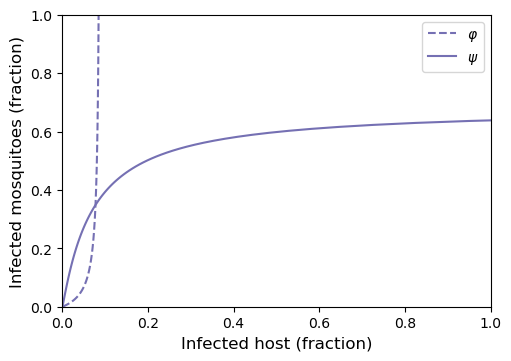

In [14]:
 # plot
fig, ax1 = plt.subplots(figsize=(5,3.5), constrained_layout=True)

# ---------- ZIKV (Cynomolgus macaques)
r_host_d, r_vector_d, varphi_d, psi_d = plotVarphiPsi(xZIKV, WHparamsZIKV, paramsWV, betaH_CM, betaM_CM)
ax1.plot(r_host_d, varphi_d, label=r'$\varphi$', linestyle='dashed', color='#7570b3')
ax1.plot(psi_d, r_vector_d, label=r'$\psi$', color='#7570b3')


ax1.set_xlabel("Infected host (fraction)", fontsize=12)
ax1.set_ylabel("Infected mosquitoes (fraction)", fontsize=12)
ax1.legend(loc='best', fontsize=10)
ax1.set_xlim(0, 1.)
ax1.set_ylim(0, 1.)
#ax1.tick_params(labelsize=12)


#plt.savefig("interceptions_linear.pdf", bbox_inches = 'tight')
plt.show()


Plot of the functions $\varphi$ and $\psi$ for parameters corresponding to DENV

In [15]:
# define the functional forms for the transmission rates beta_H and beta_M
# Note that the functions depend on the (fraction) infected host and mosquito classes, respectively,

def betaH_Hill_DENV(iH, WV_params, gamma0=np.exp(16), gamma1=9.2):
    #logWs = np.log10(0.69*Ws(iH, WV_params))
    logWs = safe_log10(0.69*Ws(iH, WV_params))
    
    b = (logWs**gamma1)/(gamma0 + logWs**gamma1)
    return b



def betaM_Hill_DENV(iM, WH_params, gamma0=np.exp(16), gamma1=9.2):
    #logV = np.log10(Vstar(iM, WH_params))
    logV = safe_log10(Vstar(iM, WH_params))
    
    b = (logV**gamma1)/(gamma0 + logV**gamma1) 
    return b

Plot

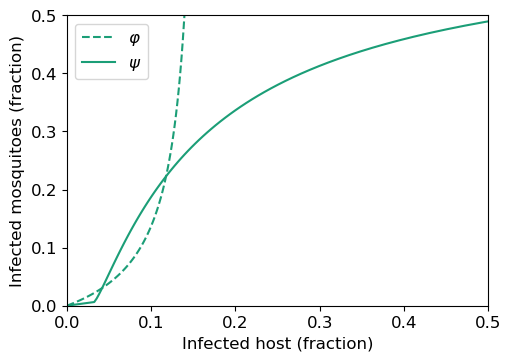

In [18]:
# plot
fig, ax1 = plt.subplots(figsize=(5,3.5), constrained_layout=True)


xDENV2 = np.array([1, 1.01, 1, 0.07, 0.67, 0.39, 1/4, 1/8, 1/4.5]) 


r_host_d, r_vector_d, varphi_d, psi_d = plotVarphiPsi(xDENV2, WHparamsDENV, paramsWV, betaH_Hill_DENV, betaM_Hill_DENV)
ax1.plot(r_host_d, varphi_d, label=r'$\varphi$', linestyle='dashed', color='#1b9e77')
ax1.plot(psi_d, r_vector_d, label=r'$\psi$', color='#1b9e77')
ax1.set_xlabel("Infected host (fraction)", fontsize=12)
ax1.set_ylabel("Infected mosquitoes (fraction)", fontsize=12)
ax1.legend(loc='best', fontsize=12)
#ax1.set_title("WNV")
ax1.set_xlim(0, 0.5)
ax1.set_ylim(0, 0.5)
ax1.tick_params(labelsize=12)

#plt.savefig("interc_nonlinearDENV_Hill.pdf", bbox_inches = 'tight')
plt.show()